<div align="right">

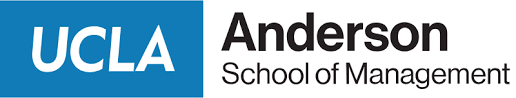

</div>

<div align="center">
<font size="5"><b>PRESCRIPTIVE MODELS AND DATA ANALYTICS</b></font>
<br>
<font size="5"><b>Problem Set #4</b></font>
<br>
This homework explores the use of Lasso for ad targeting using experimental data.
<br>
<br>
<font size="5"><b>Arnav Garg (906310841)</b></font>
</div>
<br>
<br>
<br>
<font size="4"><b>1 Simple Regression</b></font>
<br>
<br>
<font size="3.5"><b>1.1 Regression without controls</b></font>
<br>
<br>
<font size="3.5"><b>Question 1.</b> Load ad heterog data and regress revenue on treatment without further controls. The data is from an A/B test. Interpret the intercept and the treatment coefficient. </font>

The intercept coefficient means that a customer who didn't view the ad generates a revenue of \$5.1082 for the business. The treatment coefficient means that a customer who viewed an ad generates an extra revenue of \$0.6508 for the business. Both these values are statistically significant.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import sys
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

In [34]:
# Load dataset
ad_heterog = pd.read_csv('ad_heterog.csv')

# Print the number of rows and columns
print(ad_heterog.shape)

# Print the first few rows
ad_heterog.head()

(2000, 32)


,revenue,treatment,demographic_1,demographic_2,demographic_3,demographic_4,demographic_5,demographic_6,demographic_7,demographic_8,...,demographic_21,demographic_22,demographic_23,demographic_24,demographic_25,demographic_26,demographic_27,demographic_28,demographic_29,demographic_30
0,5.504899,0,1,1,1,0,0,1,1,1,...,1,1,1,1,0,1,1,1,0,1
1,5.554275,1,0,1,1,0,0,0,1,0,...,0,0,0,1,1,0,1,1,1,0
2,5.219492,0,0,1,1,0,0,1,1,1,...,0,1,0,1,0,1,1,0,0,1
3,4.565855,0,1,0,0,0,1,1,0,1,...,1,0,0,1,0,1,0,0,1,0
4,5.020636,0,1,1,0,1,0,0,1,1,...,1,1,0,0,1,1,0,0,0,1


In [35]:
# Fit a linear regression model
model = ols('revenue ~ treatment', data = ad_heterog).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     779.2
Date:                Sat, 16 Mar 2024   Prob (F-statistic):          4.50e-145
Time:                        22:25:05   Log-Likelihood:                -1532.5
No. Observations:                2000   AIC:                             3069.
Df Residuals:                    1998   BIC:                             3080.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1082      0.016    315.942      0.0

<font size="3.5"><b>Question 2.</b> Assume that it costs 0.7 Dollars to show the ad. Based on the previous regression, should you show the ad (assuming you either show it to all consumers or to nobody, i.e. you are not able to target the ad)? </font>

The marginal revenue of an ad is \$0.6508 and the marginal cost of an ad is \$0.7. Since marginal cost is higher than marginal revenue, it makes no sense to show an ad because it's not profitable.

<font size="4"><b>2 Lasso with interactions</b></font>
<br>
<br>
Run the code below in order to generate a matrix of demographic variables as well as a matrix of interaction terms.

\# extract columns pertaining to demographic information (all columns except first two)
<br>
demo_matrix = ad_heterog.iloc[:,2:]

\# generate interactions of each demographic variable with the treatment variable
<br>
demo_treat_matrix = demo_matrix.multiply(ad_heterog[’treatment’], axis="index")
<br>
demo_treat_matrix.columns = demo_treat_matrix.columns.str.replace("demographic", "treat_demo")

\# generate treatment variable that is outside of data-frame (useful below)
<br>
treatment = ad_heterog[’treatment’]

In [36]:
# extract columns pertaining to demographic information (all columns except first two)
demo_matrix = ad_heterog.iloc[:,2:]

# generate interactions of each demographic variable with the treatment variable
demo_treat_matrix = demo_matrix.multiply(ad_heterog['treatment'], axis="index")
demo_treat_matrix.columns = demo_treat_matrix.columns.str.replace("demographic", "treat_demo")

# generate treatment variable that is outside of data-frame (useful below)
treatment = ad_heterog['treatment']

In [37]:
from scipy import sparse
from sklearn import linear_model
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

<font size="3.5"><b>Question 1.</b> Run a lasso regression (not cross-validated yet) without standardization using treatment and the interaction term matrix as X variables (note that we are NOT also using the demographic variables as controls here). Plot how the coefficients behave when changing the penalty parameter. Why do you think the first line (from right to left) is non-monotonic (i.e. it first increases and then decreases)? </font>

We see that the blue line in the graph first increases and then decreases from right to left in non-monotonic fashion. This happens because when the penalty parameter is too large (right), it prevents any variable from having any significant contribution in the model. Hence, the coefficient of this variable struggles to be large enough and is lower than it should be. When the penalty parameter is too small, it leverages every variable to have a contribution, even if it's insignificant. Hence, the variables have to fight for their contribution and the coefficient of this variable fights to be as large as it should be. Therefore, as we can see in the graph that there exists an optimal value of penalty parameter in the middle where the coefficient is at the peak and has the largest contribution in the model as compared to other variables. This graph highlights how LASSO ensures an optimal fit using a subset of influential variables which have the highest contribution.

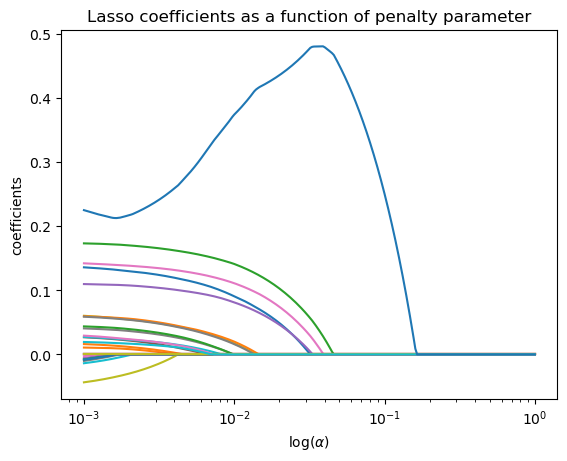

In [38]:
# X variable for LASSO
X = pd.concat([demo_treat_matrix, treatment], axis=1)

# Y variable for LASSO
Y = ad_heterog['revenue']

# Compute paths
n_alpha = 250
alphas = np.logspace(-3, 0, n_alpha)
coefs = []
for a in alphas:
    lasso = linear_model.Lasso(alpha = a, max_iter = 5000)
    lasso.fit(X, Y)
    coefs.append(lasso.coef_)

# Display results
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
plt.xlabel("$\log(\\alpha)$")
plt.ylabel("coefficients")
plt.title("Lasso coefficients as a function of penalty parameter") 
plt.axis("tight")
plt.show()


<font size="3.5"><b>Question 2.</b> Run the cross-validated lasso (without standardization) based on the same set of variables. Report the coefficient values for all non-zero coefficients at the optimal penalty value. What do the results suggest regarding the scope for targeting? </font>

The optimal penalty value is 0.00496 and we obtain 14 variables with non-zero coefficents. The intercept represents revenue without advertisement and the treatment coefficient represents the overall impact of advertisement across all demographics. The non-zero interaction terms represent the impact of advertisement across those particular demographics, with a higher coefficient suggesting a higher impact. Hence, advertisements can be targeted to demographics with higher coefficients to earn more revenue and ROI on ad campaigns.

In [39]:
# X variables for LASSO
X = pd.concat([demo_treat_matrix, treatment], axis=1)

# Y variable for LASSO
Y = ad_heterog['revenue']

lasso = LassoCV(alphas = None, cv = 10, max_iter = 10000)
lasso.fit(X, Y)

print(f"Best alpha: {lasso.alpha_}")
print(f"Best score: {lasso.score(X, Y)}")
print(f"Intercept: {lasso.intercept_}")
for i in range(len(lasso.coef_)):
    if lasso.coef_[i] != 0:
        print(f"{X.columns[i]}: {lasso.coef_[i]}")

Best alpha: 0.004961131928368485
Best score: 0.31405692550599573
Intercept: 5.117741819418822
treat_demo_1: 0.11479145525073149
treat_demo_3: 0.15861393381905967
treat_demo_7: 0.1282662735581015
treat_demo_9: 0.03999783927590587
treat_demo_16: 0.006874816749559626
treat_demo_18: 0.02234609980162754
treat_demo_20: 0.012208907418115676
treat_demo_22: 0.04113335329560702
treat_demo_23: 0.02431896294803566
treat_demo_25: 0.09785579108782104
treat_demo_27: 0.010832419607162224
treat_demo_28: 0.03894119230574026
treat_demo_30: 0.008046143631867902
treatment: 0.2810755839513504


<font size="4"><b>3 Lasso with baseline and interacted demographics</b></font>
<br>
<br>
<font size="3.5"><b>Question 1.</b> Run a cross-validated lasso based on the same variables as above, but now also include the un-interacted demographic variables to the matrix of X variables to try for lasso. Make sure you know how to interpret the coefficients for the demographics that are selected as both slope and intercept dummies as opposed to the demographics that only show up as interaction dummies. For example, consider the case of demographics 3 and 7. Can you compute the treatment effect for both characteristics (i.e., the effect of the treatment on individuals with a certain characteristic vs. individuals with the same characteristic in the control group?). </font>

We observe that demographic 3 is only selected as an interaction dummy. This means that on its own, demographic 3 doesn't inherently have a higher tendency to generate more revenue. However, when treated with an advertisement, they are 0.154872 units more likely to respond to the advertisement and generate revenue. \
However, demographic 7 is selected both as an interaction dummy and on its own. This means that demographic 7 inherently have a 0.016425 units higher tendency to generate more revenue, but when treated with an advertisement, they have an even higher tendency to generate revenue by an additional 0.090898 units.

In [40]:
# X variables for LASSO
X = pd.concat([demo_matrix, demo_treat_matrix, treatment], axis=1)

# Y variable for LASSO
Y = ad_heterog['revenue']

lasso = LassoCV(alphas = None, cv = 10, max_iter = 10000)
lasso.fit(X, Y)

print(f"Best alpha: {lasso.alpha_}")
print(f"Best score: {lasso.score(X, Y)}")
print(f"Intercept: {lasso.intercept_}")
for i in range(len(lasso.coef_)):
    if lasso.coef_[i] != 0:
        print(f"{X.columns[i]}: {lasso.coef_[i]}")

Best alpha: 0.006116315321831016
Best score: 0.3314046530468263
Intercept: 4.96509054995117
demographic_1: 0.1380444049598565
demographic_2: -0.0027896113610828524
demographic_7: 0.01642266800735618
demographic_9: 0.03416135654076235
demographic_11: -0.014060328316184999
demographic_22: 0.03223387060078546
demographic_23: 0.020893223347081373
demographic_25: 0.06822798885142098
demographic_28: 0.013995905722375109
treat_demo_3: 0.15487285218654512
treat_demo_7: 0.10732169111389081
treat_demo_9: 0.0020555642629011975
treat_demo_16: 0.0014524788923802104
treat_demo_18: 0.017429886181186134
treat_demo_20: 0.008343102770357496
treat_demo_22: 0.004225583434372749
treat_demo_25: 0.0253787684176341
treat_demo_27: 0.006158213629005911
treat_demo_28: 0.02034925749398393
treat_demo_30: 0.0033173994416277677
treatment: 0.45465199391534467


<font size="3.5"><b>Question 2.</b> For each observation, compute predicted revenue without and with treatment. Use those two predictions to compute the expected profit per consumer when showing the ad to everybody versus when showing the ad only to consumers with positive expected profit. </font>

When we don't target our advertisements and show it to everybody, we observe a loss of \$0.0683 per advertisement on average. However, if we target our advertisements only to demographics with positive expected profits, we observe a profit of \$0.0619. Hence, through targeted advertisement we are able to optimise our campaigns and earn a better ROI.

In [41]:
treat = ad_heterog.copy()
notreat = ad_heterog.copy()

####### With treatment #######
treat['treatment'] = 1

demo_matrix = treat.iloc[:,2:]
demo_treat_matrix = demo_matrix.multiply(treat['treatment'], axis="index")
demo_treat_matrix.columns = demo_treat_matrix.columns.str.replace("demographic", "treat_demo")
treatment = treat['treatment']

# X variables for LASSO
X = pd.concat([demo_matrix, demo_treat_matrix, treatment], axis=1)

# Predict
ad_heterog['revenue_pred_treat1'] = lasso.predict(X)

####### Without treatment #######
notreat['treatment'] = 0

demo_matrix = notreat.iloc[:,2:]
demo_treat_matrix = demo_matrix.multiply(notreat['treatment'], axis="index")
demo_treat_matrix.columns = demo_treat_matrix.columns.str.replace("demographic", "treat_demo")
treatment = notreat['treatment']

# X variables for LASSO
X = pd.concat([demo_matrix, demo_treat_matrix, treatment], axis=1)

# Predict
ad_heterog['revenue_pred_treat0'] = lasso.predict(X)

##################################

ad_heterog['profit'] = ad_heterog['revenue_pred_treat1'] - ad_heterog['revenue_pred_treat0'] - 0.7 #subtract marginal cost of advertising
ad_heterog

,revenue,treatment,demographic_1,demographic_2,demographic_3,demographic_4,demographic_5,demographic_6,demographic_7,demographic_8,...,demographic_24,demographic_25,demographic_26,demographic_27,demographic_28,demographic_29,demographic_30,revenue_pred_treat1,revenue_pred_treat0,profit
0,5.504899,0,1,1,1,0,0,1,1,1,...,1,0,1,1,1,0,1,5.956945,5.203992,0.052953
1,5.554275,1,0,1,1,0,0,0,1,0,...,1,1,0,1,1,1,0,5.861632,5.081049,0.080584
2,5.219492,0,0,1,1,0,0,1,1,1,...,1,0,1,1,0,0,1,5.768731,5.010957,0.057773
3,4.565855,0,1,0,0,0,1,1,0,1,...,1,0,1,0,0,1,0,5.569500,5.089075,-0.219575
4,5.020636,0,1,1,0,1,0,0,1,1,...,0,1,1,0,0,0,1,5.875568,5.251391,-0.075824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,6.685725,1,1,1,0,0,0,1,1,0,...,1,1,1,1,1,1,0,5.887392,5.254046,-0.066655
1996,6.707116,1,0,0,0,0,1,0,1,1,...,0,1,0,0,1,1,1,5.762609,5.136965,-0.074357
1997,5.522816,1,1,0,1,1,0,0,1,1,...,0,1,1,1,1,0,1,5.997441,5.221883,0.075558
1998,4.787769,1,1,0,0,0,1,1,1,1,...,1,0,0,0,1,0,1,5.802320,5.186681,-0.084361


In [42]:
print(f"Average profit without advertisement targeting: {round(ad_heterog['profit'].mean(), 5)}")
print(f"Average profit with advertisement targeting: {round(ad_heterog.loc[ad_heterog.profit >= 0]['profit'].mean(), 5)}")

Average profit without advertisement targeting: -0.0683
Average profit with advertisement targeting: 0.06191
